In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext Cython

In [15]:
%%cython -a
cimport cython
cimport numpy as np
import  numpy as np
from libc.math cimport sqrt

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef int _rotation(double [:,::1] input_data, double [:,::1] output_data):
    cdef Py_ssize_t r_len, s_len
    r_len = input_data.shape[1]
    s_len = input_data.shape[0]
    cdef Py_ssize_t r_len_half = r_len // 2
        
    cdef Py_ssize_t yy, xx ,rr
    cdef double radius 
    cdef double summed_line_up, summed_line_down
    
    # no interpolation
    # add interpolation later
    
    if  r_len%2 == 0:
        for zz in range(s_len):
            for yy in range(r_len_half):
                summed_line_up = 0
                summed_line_down = 0
                for xx in range(r_len_half - yy, 0 , -1):
                    radius = sqrt((yy+0.5)**2 + (xx-0.5)**2)
                    rr = int(radius) 
                    summed_line_up += (input_data[zz,r_len_half  + rr] 
                                       * (yy + 0.5)/radius)
                    summed_line_down += (input_data[zz,r_len_half - 1  - rr] 
                                         * (yy + 0.5)/radius)
                output_data[r_len_half - 1 -yy ,zz] = summed_line_up
                output_data[r_len_half +  yy, zz]  = summed_line_down
            
    if r_len%2 != 0:
        #calculate the middle line
        for zz in range(s_len):
            for yy in range(1, r_len_half):
                summed_line_up = 0
                summed_line_down = 0
                for xx in range(r_len_half - yy, 0 , -1):
                    radius = sqrt((yy)**2 + (xx-0.5)**2)
                    rr = int(radius) 
                    summed_line_up += (input_data[zz,r_len_half  + rr] 
                                       * (yy + 0.5)/radius)
                    summed_line_down += (input_data[zz,r_len_half  - rr] 
                                         * (yy + 0.5)/radius)
                output_data[r_len_half - yy ,zz] = summed_line_up
                output_data[r_len_half +  yy, zz]  = summed_line_down
            #
            yy = 0
            summed_line_up = 0
            for xx in range(r_len_half - yy, 0 , -1):
                radius = sqrt((yy+0.25)**2 + (xx-0.5)**2)
                rr = int(radius)
                summed_line_up += (input_data[zz,r_len_half  + rr] 
                                       * (yy + 0.25)/radius)
                output_data[r_len_half - yy ,zz] = summed_line_up
            
        return 1
    return 0

def rotation(input_data):
    try:
        input_data.flags
    except AttributeError:
        print('input_data should be a numpy array!')
        raise
    if input_data.flags['F_CONTIGUOUS']:
        print('input_data should be stored in a raw major, C contigous.')
    elif not input_data.flags['C_CONTIGUOUS']:
        print('input_data as to be a contigous array.')
    
    if input_data.type != np.float64:
        print('input should be an ndarray of type np.float64.')
        print('Converting to float64 and continuing...')
        input_data = input_data.astype(np.float64)

    output = np.zeros(input_data.size, dtype=np.float64, order='C').reshape(
                    input_data.shape[1], input_data.shape[0])
    
    cdef double [:,::1] input_data_view = input_data
    cdef double [:,::1] output_view = output
    # returned_status just for debugging, flow control. To be removed!
    returned_status = _rotation(input_data_view, output_view)
    print(returned_status)
    return output

In [16]:
path = '../../Faraday_Rotation/test_samples/'

In [58]:
file_name = 'sim'

In [59]:
test_sample = np.load(path + file_name + '.npy')

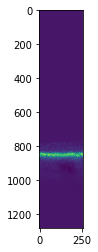

In [60]:
plt.imshow(test_sample)

In [61]:
test_sample[750,200]

0.0

In [67]:
rotated = rotation(np.ascontiguousarray(test_sample[::-1,:]).astype(np.float64))

0


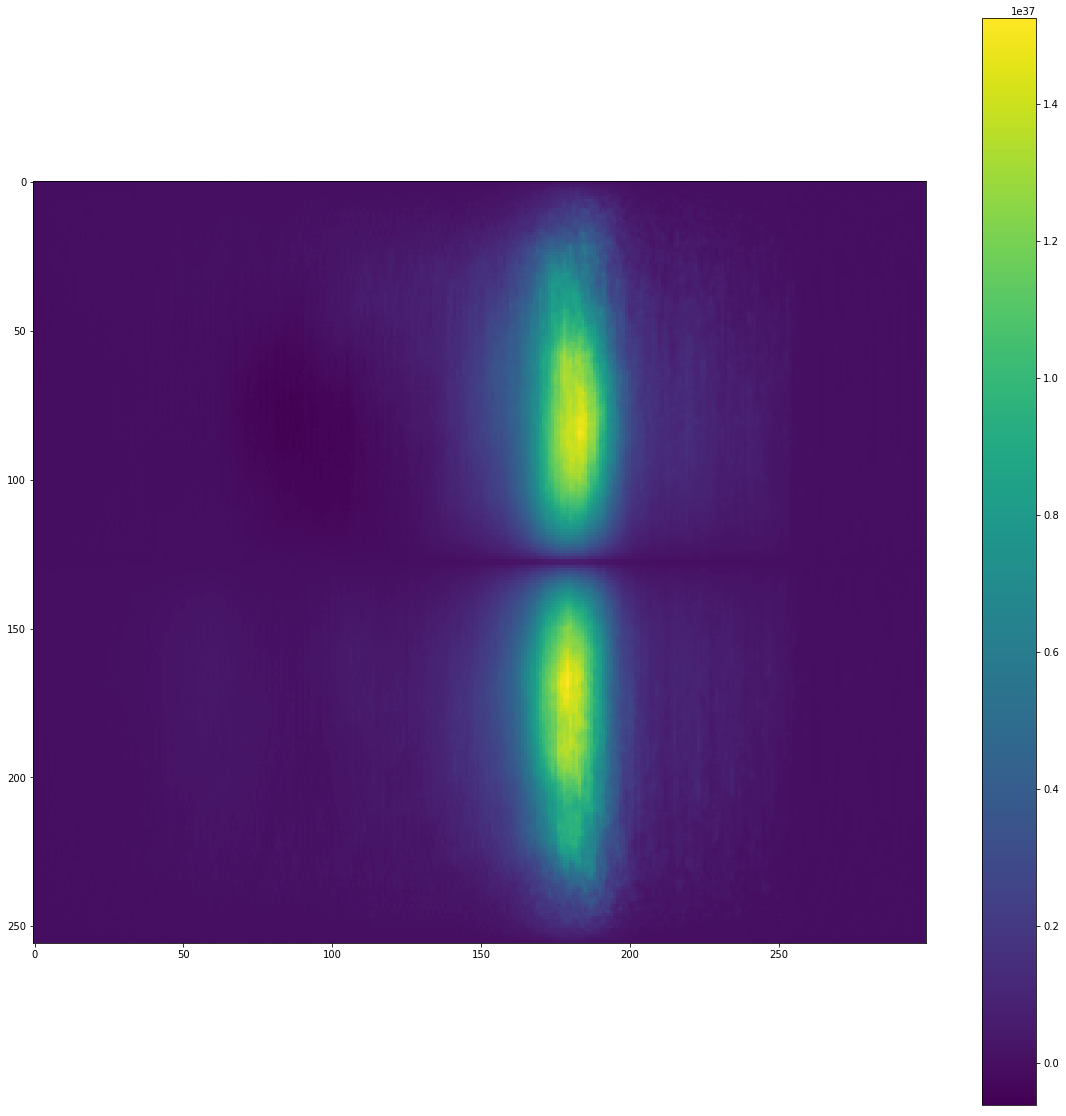

In [66]:
f, ax = plt.subplots(1, figsize=(20,20))
ax.imshow(rotated[:,250:550])
f.colorbar(ax.images[0])
#f.savefig('out3.jpg')